In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [12]:
class MultiHeadAttentionModified(torch.nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.d_key = dim // num_heads #每个头的维度

        # 线性层用于生成Q, K, V
        self.linear_q = torch.nn.Linear(dim, dim)
        self.linear_k = torch.nn.Linear(dim, dim)
        self.linear_v = torch.nn.Linear(dim, dim)

        # 最后的线性变换
        self.final_linear = torch.nn.Linear(dim, dim)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # 生成Q, K, V
        Q = self.linear_q(x).view(batch_size, seq_length, self.num_heads, self.d_key)
        K = self.linear_k(x).view(batch_size, seq_length, self.num_heads, self.d_key)
        V = self.linear_v(x).view(batch_size, seq_length, self.num_heads, self.d_key)

        # 转置以匹配形状，以便进行批量点乘
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)

        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_key, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)

        # 应用注意力权重到V
        attention_output = torch.matmul(attention_weights, V)

        # 拼接所有头
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.dim)

        # 最后的线性变换
        output = self.final_linear(attention_output)

        return output, attention_weights

# 使用新的参数名
dim = 512  # 输入维度
num_heads = 8  # 多头数量
mha_modified = MultiHeadAttentionModified(dim, num_heads)

# 随机生成输入数据
x = torch.rand(1, 10, dim)  # (batch_size, seq_length, dim)

# 计算多头注意力
_, attention_weights_modified = mha_modified(x)

# 查看注意力权重的形状
attention_weights_modified.shape



torch.Size([1, 8, 10, 10])

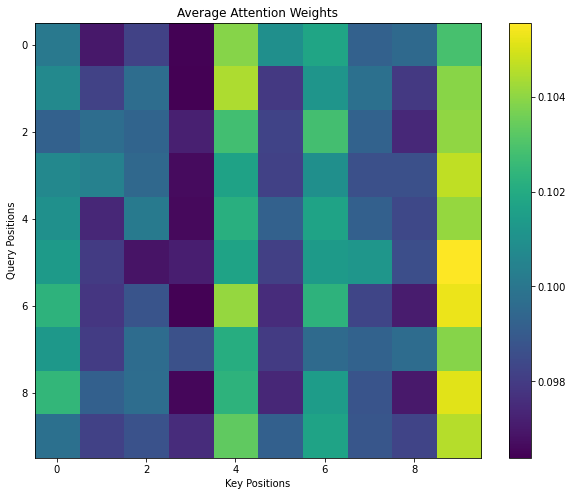

In [15]:
# 计算所有头的平均注意力权重
average_attention_weights = attention_weights_modified.mean(dim=1).squeeze(0).detach().numpy()

# 绘制所有头平均注意力权重的热力图
plt.figure(figsize=(10, 8))
plt.imshow(average_attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Average Attention Weights")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()
